# Unsupervised Learning of Syntactic Structure with Invertible Neural Projections,

This code is based on https://github.com/jxhe/struct-learning-with-flow . We need to change the Markov Model class and some functions in a way that it can run on Google Colab and it stores the word embeddings that are attained by the model which is proposed by [Unsupervised Learning of Syntactic Structure with Invertible Neural Projections](http://arxiv.org/abs/1808.09111http://arxiv.org/abs/1808.09111)

## Setup

In [ ]:
# Running this cell is neccesary due to the fact that
# installing faiss 1.6.5 via pip is not working for torchcuda
# However, it will restart the kernel.
# After that, you should continue with the next cell and reload the page.

!pip install -q condacolab
import condacolab

condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In [1]:
import condacolab

condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# It will override the conda pinned versions to install required version of cuda
!echo python 3.7.*   > /usr/local/conda-meta/pinned
!echo python_abi 3.7.* *cp37*  >> /usr/local/conda-meta/pinned
!conda install faiss=1.6.5 cudatoolkit=10.1 -c pytorch # For CUDA10
!pip install -q tsnecuda==3.0.0+cu101 -f https://tsnecuda.isx.ai/tsnecuda_stable.html
!git clone https://github.com/jxhe/struct-learning-with-flow.git

# Rename original repo
!mv /content/struct-learning-with-flow /content/struct_learning_with_flow

Solving environment: / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=10.1
    - faiss=1.6.5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_0         3.1 MB  conda-forge
    cudatoolkit-10.1.243       |       h036e899_8       427.5 MB  conda-forge
    faiss-1.6.5                |py37hc041386_0_cuda         917 KB  conda-fo

In [3]:
%cd /content/struct_learning_with_flow
!python prepare_data.py

/content/struct_learning_with_flow


In [4]:
import sys
import time
import os
from __future__ import print_function
from collections import defaultdict
from collections import Counter
from functools import partial
import pickle
import math
from math import log
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

import argparse
from argparse import Namespace

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import tsnecuda as TSNE

from sklearn.metrics.cluster import v_measure_score

from struct_learning_with_flow.modules.utils import (
    read_conll,
    to_input_tensor,
    data_iter,
    generate_seed,
    sents_to_vec,
    log_sum_exp,
)
from struct_learning_with_flow.modules.projection import *
from struct_learning_with_flow.modules.markov_flow_model import MarkovFlow as mf

In [5]:
def write_conll(fname, sentences, pred_tags, null_total, embeddings):
    # Embeddings have 123 elements in it, therefore each sentence has its embedding
    embed_dict = {}
    with open(fname, "w") as fout:
        for (pred, null_sent, sent, embed) in zip(pred_tags, null_total, sentences, embeddings):
            word_list = sent["word"]
            embed = list(embed)
            head_list = sent["head"]
            length = len(sent) + len(null_sent)

            assert length == len(head_list)

            pred_tag_list = [str(k.item()) for k in pred]
            for null in null_sent:
                embed.insert(null, np.zeros(embed[0].shape))
                pred_tag_list.insert(null, "-NONE-")
                word_list.insert(null, "-NONE-")

            for i in range(length):
                fout.write("{}\t{}\t{}\t{}\n".format(i + 1, word_list[i], pred_tag_list[i], head_list[i][1]))
                if not word_list[i] in embed_dict and i not in null_sent:
                    embed_dict[word_list[i]] = embed[i]
            fout.write("\n")

    with open("/content/word_embeddings.pkl", "wb") as fout:
        pickle.dump(embed_dict, fout)

In [6]:
class MarkovFlow(mf):
    def __init__(self, args, num_dims):
        super(MarkovFlow, self).__init__(args, num_dims)

    def test(self, test_data, test_tags, sentences=None, tagging=False, path=None, null_index=None):
        """Evaluate tagging performance with
        many-to-1 metric and VM score

        Args:
            test_data: nested list of sentences
            test_tags: nested list of gold tags
            tagging: output the predicted tags if True
            path: The output tag file path
            null_index: the null element location in Penn
                        Treebank, only used for writing unsupervised
                        tags for downstream parsing task

        Returns:
            Tuple1: (M1, VM score)

        """

        pad = np.zeros(self.num_dims)

        total = 0.0
        correct = 0.0
        cnt_stats = {}
        match_dict = {}

        index_all = []
        eval_tags = []

        gold_vm = []
        model_vm = []
        embeddings_ = []

        for sents, tags in data_iter(
            list(zip(test_data, test_tags)), batch_size=self.args.batch_size, is_test=True, shuffle=False
        ):
            total += sum(len(sent) for sent in sents)
            sents_var, masks = to_input_tensor(sents, pad, device=self.device)
            sents_var, _ = self.transform(sents_var)
            embeddings_.extend(np.swapaxes(sents_var.cpu().numpy(), 0, 1))

            # index: (batch_size, seq_length)
            index = self._viterbi(sents_var, masks)

            index_all += list(index)
            eval_tags += tags

            # count
            for (seq_gold_tags, seq_model_tags) in zip(tags, index):
                for (gold_tag, model_tag) in zip(seq_gold_tags, seq_model_tags):
                    model_tag = model_tag.item()
                    gold_vm += [gold_tag]
                    model_vm += [model_tag]
                    if model_tag not in cnt_stats:
                        cnt_stats[model_tag] = Counter()
                    cnt_stats[model_tag][gold_tag] += 1
        # match
        for tag in cnt_stats:
            match_dict[tag] = cnt_stats[tag].most_common(1)[0][0]

        # eval many2one
        for (seq_gold_tags, seq_model_tags) in zip(eval_tags, index_all):
            for (gold_tag, model_tag) in zip(seq_gold_tags, seq_model_tags):
                model_tag = model_tag.item()
                if match_dict[model_tag] == gold_tag:
                    correct += 1

        if tagging:
            write_conll(path, sentences, index_all, null_index, embeddings_)

        return correct / total, v_measure_score(gold_vm, model_vm)

In [7]:
def init_config(
    train_file,
    word_vec,
    model="gaussian",
    test_file="",
    batch_size=32,
    epochs=50,
    lr=0.001,
    num_state=45,
    couple_layers=4,
    cell_layers=1,
    hidden_units=50,
    load_nice="",
    load_gaussian="",
    valid_nepoch=1,
    tag_from="",
    seed=5783287,
    set_seed=False,
    jobid=0,
    taskid=0,
):

    kwargs = {
        "model": model,
        "train_file": train_file,
        "word_vec": word_vec,
        "couple_layers": couple_layers,
        "test_file": test_file,
        "batch_size": batch_size,
        "epochs": epochs,
        "lr": lr,
        "num_state": num_state,
        "couple_layers": couple_layers,
        "cell_layers": cell_layers,
        "hidden_units": hidden_units,
        "load_nice": load_nice,
        "load_gaussian": load_gaussian,
        "valid_nepoch": valid_nepoch,
        "tag_from": tag_from,
        "seed": seed,
        "set_seed": set_seed,
        "jobid": jobid,
        "taskid": taskid,
    }

    args = Namespace(**kwargs)
    args.cuda = torch.cuda.is_available()

    save_dir = "dump_models/markov"

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    id_ = "pos_%s_%dlayers_%d_%d" % (args.model, args.couple_layers, args.jobid, args.taskid)
    save_path = os.path.join(save_dir, id_ + ".pt")
    args.save_path = save_path
    print("model save path: ", save_path)

    if args.tag_from != "":
        if args.model == "nice":
            args.load_nice = args.tag_from
        else:
            args.load_gaussian = args.tag_from
        args.tag_path = "pos_%s_%slayers_tagging%d_%d.txt" % (args.model, args.couple_layers, args.jobid, args.taskid)

    if args.set_seed:
        torch.manual_seed(args.seed)
        if args.cuda:
            torch.cuda.manual_seed(args.seed)
        np.random.seed(args.seed * 13 / 7)

    print(args)

    return args

In [8]:
def main(args):

    word_vec = pickle.load(open(args.word_vec, "rb"))
    print("complete loading word vectors")

    train_text, null_index = read_conll(args.train_file)
    if args.test_file != "":
        test_text, null_index = read_conll(args.test_file)
    else:
        test_text = train_text

    train_data = sents_to_vec(word_vec, train_text)
    test_data = sents_to_vec(word_vec, test_text)

    test_tags = [sent["tag"] for sent in test_text]

    num_dims = len(train_data[0][0])
    print("complete reading data")

    print("#training sentences: %d" % len(train_data))
    print("#testing sentences: %d" % len(test_data))

    log_niter = (len(train_data) // args.batch_size) // 10

    pad = np.zeros(num_dims)
    device = torch.device("cuda" if args.cuda else "cpu")
    args.device = device
    init_seed = to_input_tensor(generate_seed(train_data, args.batch_size), pad, device=device)

    model = MarkovFlow(args, num_dims).to(device)

    model.init_params(init_seed)

    if args.tag_from != "":
        model.eval()
        with torch.no_grad():
            accuracy, vm = model.test(
                test_data, test_tags, sentences=test_text, tagging=True, path=args.tag_path, null_index=null_index
            )
        print(
            "\n***** M1 %f, VM %f, max_var %.4f, min_var %.4f*****\n"
            % (accuracy, vm, model.var.data.max(), model.var.data.min())
        )
        return

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    begin_time = time.time()
    print("begin training")

    train_iter = report_obj = report_jc = report_ll = report_num_words = 0

    # print the accuracy under init params
    model.eval()
    with torch.no_grad():
        accuracy, vm = model.test(test_data, test_tags)
    print(
        "\n*****starting M1 %f, VM %f, max_var %.4f, min_var %.4f*****\n"
        % (accuracy, vm, model.var.data.max(), model.var.data.min())
    )

    model.train()
    for epoch in range(args.epochs):
        # model.print_params()
        report_obj = report_jc = report_ll = report_num_words = 0
        for sents in data_iter(train_data, batch_size=args.batch_size, shuffle=True):
            train_iter += 1
            batch_size = len(sents)
            num_words = sum(len(sent) for sent in sents)
            sents_var, masks = to_input_tensor(sents, pad, device=args.device)
            optimizer.zero_grad()
            likelihood, jacobian_loss = model(sents_var, masks)
            neg_likelihood_loss = -likelihood

            avg_ll_loss = (neg_likelihood_loss + jacobian_loss) / batch_size

            avg_ll_loss.backward()

            optimizer.step()

            log_likelihood_val = -neg_likelihood_loss.item()
            jacobian_val = -jacobian_loss.item()
            obj_val = log_likelihood_val + jacobian_val

            report_ll += log_likelihood_val
            report_jc += jacobian_val
            report_obj = obj_val
            report_num_words += num_words

            if train_iter % log_niter == 0:
                print(
                    "epoch %d, iter %d, log_likelihood %.2f, jacobian %.2f, obj %.2f, max_var %.4f "
                    "min_var %.4f time elapsed %.2f sec"
                    % (
                        epoch,
                        train_iter,
                        report_ll / report_num_words,
                        report_jc / report_num_words,
                        report_obj / report_num_words,
                        model.var.max(),
                        model.var.min(),
                        time.time() - begin_time,
                    )
                )

        print(
            "\nepoch %d, log_likelihood %.2f, jacobian %.2f, obj %.2f\n"
            % (epoch, report_ll / report_num_words, report_jc / report_num_words, report_obj / report_num_words)
        )

        if epoch % args.valid_nepoch == 0:
            model.eval()
            with torch.no_grad():
                accuracy, vm = model.test(test_data, test_tags)
            print("\n*****epoch %d, iter %d, M1 %f, VM %f*****\n" % (epoch, train_iter, accuracy, vm))
            model.train()

        torch.save(model.state_dict(), args.save_path)

    model.eval()
    with torch.no_grad():
        accuracy, vm = model.test(test_data, test_tags)
    print("\n complete training, accuracy %f, vm %f\n" % (accuracy, vm))

# Training a Gaussian HMM

Running two cells below equivalent to

```
python markov_flow_train.py --model gaussian --train_file /path/to/train --word_vec /path/to/word_vec_file
```


In [9]:
train_file = "/content/struct_learning_with_flow/sample_data/ptb_tag_train_sub.txt"
word_vec = "/content/struct_learning_with_flow/sample_data/wsj_word_vec.pkl"
couple_layers = 4

In [10]:
args = init_config(train_file, word_vec, couple_layers=couple_layers, lr=5e-3)
main(args)

model save path:  dump_models/markov/pos_gaussian_4layers_0_0.pt
Namespace(batch_size=32, cell_layers=1, couple_layers=4, cuda=True, epochs=50, hidden_units=50, jobid=0, load_gaussian='', load_nice='', lr=0.005, model='gaussian', num_state=45, save_path='dump_models/markov/pos_gaussian_4layers_0_0.pt', seed=5783287, set_seed=False, tag_from='', taskid=0, test_file='', train_file='/content/struct_learning_with_flow/sample_data/ptb_tag_train_sub.txt', valid_nepoch=1, word_vec='/content/struct_learning_with_flow/sample_data/wsj_word_vec.pkl')
complete loading word vectors
complete reading data
#training sentences: 3914
#testing sentences: 3914
begin training

*****starting M1 0.432900, VM 0.366470, max_var 0.0106, min_var 0.0046*****

epoch 0, iter 12, log_likelihood 116.42, jacobian 0.00, obj 10.27, max_var 0.0106 min_var 0.0046 time elapsed 7.42 sec
epoch 0, iter 24, log_likelihood 121.82, jacobian 0.00, obj 4.77, max_var 0.0106 min_var 0.0046 time elapsed 8.11 sec
epoch 0, iter 36, log

## Training Normalising Flows

Following cells are used for the training of a projection model with Markov prior instead of

```
python markov_flow_train.py \
        --model nice \
        --lr 0.01 \
        --train_file /path/to/train \
        --word_vec /path/to/word_vec_file \
        --load_gaussian /path/to/gaussian_model
```




In [11]:
load_gaussian = f"/content/struct_learning_with_flow/dump_models/markov/pos_gaussian_{couple_layers}layers_0_0.pt"
model = "nice"
lr = 0.01

In [ ]:
args = init_config(train_file, word_vec, lr=lr, model=model, couple_layers=couple_layers, load_gaussian=load_gaussian)
main(args)

## Evaluation on Test Data

We evaluate on the training data, you can test on different dataset which can be specified via passing the path to `init_config` function as `test_file` argument

In [13]:
tag_from = f"/content/struct_learning_with_flow/dump_models/markov/pos_nice_{couple_layers}layers_0_0.pt"

In [14]:
args = init_config(train_file, word_vec, model=model, lr=lr, tag_from=tag_from, couple_layers=couple_layers)
main(args)

model save path:  dump_models/markov/pos_nice_4layers_0_0.pt
Namespace(batch_size=32, cell_layers=1, couple_layers=4, cuda=True, epochs=50, hidden_units=50, jobid=0, load_gaussian='', load_nice='/content/struct_learning_with_flow/dump_models/markov/pos_nice_4layers_0_0.pt', lr=0.01, model='nice', num_state=45, save_path='dump_models/markov/pos_nice_4layers_0_0.pt', seed=5783287, set_seed=False, tag_from='/content/struct_learning_with_flow/dump_models/markov/pos_nice_4layers_0_0.pt', tag_path='pos_nice_4layers_tagging0_0.txt', taskid=0, test_file='', train_file='/content/struct_learning_with_flow/sample_data/ptb_tag_train_sub.txt', valid_nepoch=1, word_vec='/content/struct_learning_with_flow/sample_data/wsj_word_vec.pkl')
complete loading word vectors
complete reading data
#training sentences: 3914
#testing sentences: 3914

***** M1 0.778347, VM 0.717845, max_var 0.0128, min_var 0.0036*****



## Ordinal Encoding of POS Tags 

In [95]:
from sklearn.preprocessing import OrdinalEncoder

# define data
# define ordinal encoding
data = pd.read_csv(
    "/content/struct_learning_with_flow/sample_data/ptb_tag_train_sub.txt", delim_whitespace=True, header=None
)
data = data.drop(columns=[0, 3, 4])
data = data[data[2] != "-NONE-"]

encoder = OrdinalEncoder()
# transform data
data["idx"] = encoder.fit_transform(data[2].to_numpy().reshape((-1, 1))).astype(int)

## Colors Assocaited with POS Tags

We create our own color map for the better visualization of word embeddingss

In [96]:
discrete_colors = np.vstack(
    (
        plt.cm.tab20b(np.linspace(0, 1, 25))[:5],
        plt.cm.tab20c(np.linspace(0, 1, 25))[:5],
        plt.cm.tab20b(np.linspace(0, 1, 25))[-10:],
        plt.cm.tab20c(np.linspace(0, 1, 25))[5:10],
        plt.cm.Set2(np.linspace(0, 1, 8)),
        plt.cm.Set3(np.linspace(0, 1, 12)),
    )
)
color_map = matplotlib.colors.LinearSegmentedColormap.from_list("spec_cmap", discrete_colors)

In [97]:
tags = [data[data["idx"] == i][2].unique()[0] for i in range(45)]

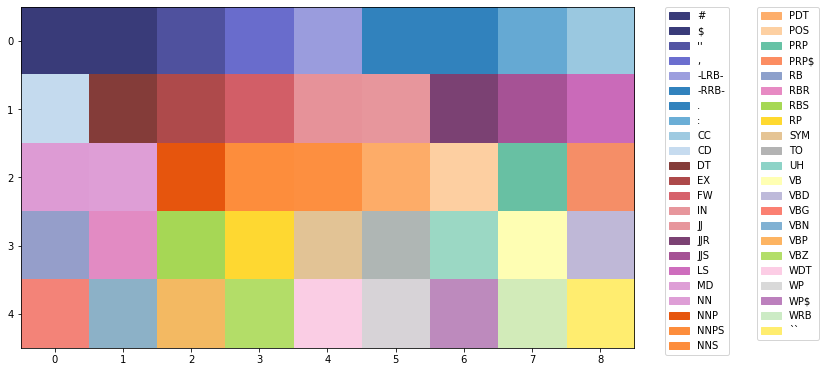

In [98]:
plt.figure(figsize=(11, 18))
discrete_colors_matrix = np.arange(0, 45).reshape(5, 9)
plt.imshow(discrete_colors_matrix, cmap=color_map)
patches1 = [
    mpatches.Patch(color=discrete_colors[i], label=data[data["idx"] == i][2].unique()[0]) for i in range(23, 45)
]
legend1 = plt.legend(handles=patches1, bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.0)
patches2 = [mpatches.Patch(color=discrete_colors[i], label=data[data["idx"] == i][2].unique()[0]) for i in range(23)]
plt.legend(handles=patches2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.gca().add_artist(legend1)
plt.show()

## Word Embeddings

In [99]:
embeddings = pd.read_pickle("/content/struct_learning_with_flow/sample_data/wsj_word_vec.pkl")
data["embeddings"] = data[1].apply(lambda x: embeddings[x])

x = np.vstack(data.embeddings.to_numpy())
y = data["idx"].to_numpy()

tsne = TSNE.TSNE(perplexity=40, random_seed=0, n_iter=500, learning_rate=175)
tsne_result = tsne.fit_transform(x)

In [100]:
embeddings = pd.read_pickle("/content/word_embeddings.pkl")
data["embeddings"] = data[1].apply(lambda x: embeddings[x] if x in embeddings else embeddings["0"])

x = np.vstack(data.embeddings.to_numpy())
new_tsne_result = tsne.fit_transform(x)

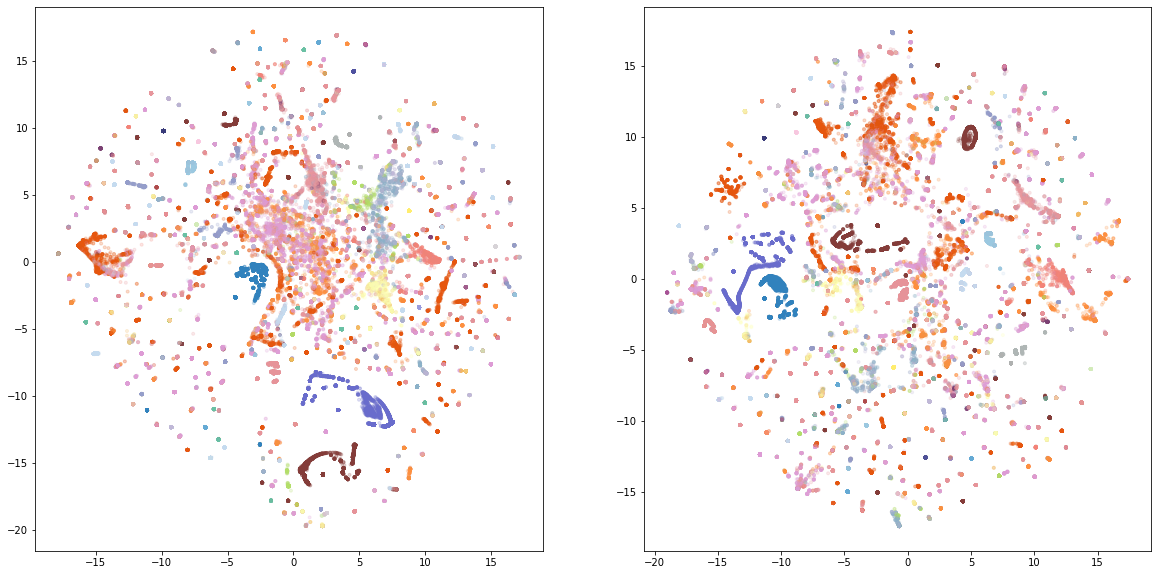

In [101]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap=color_map, c=list(map(int, y)), alpha=0.2, marker=".")
plt.subplot(1, 2, 2)
plt.scatter(new_tsne_result[:, 0], new_tsne_result[:, 1], cmap=color_map, c=list(map(int, y)), alpha=0.2, marker=".")
plt.show()